In [8]:
# Standard library imports
import os
import sys
import importlib
import numpy as np
import random
import cv2
from tqdm import tqdm

# Add project-specific paths
sys.path.append(os.path.join(os.getcwd(), 'common'))

# Import custom modules
import utility
import embedding
import detection
import grt
import attacks

# Reload module for updates
importlib.reload(grt)

importlib.reload(utility)
importlib.reload(detection)
importlib.reload(attacks)
importlib.reload(embedding)

<module 'embedding' from '/home/make/multimedia/multimedia-data-security/common/embedding.py'>

In [9]:
def robustness_point(avg):
    if avg >= 53:
        points = 0
    elif avg >= 50:
        points = 1
    elif avg >= 47:
        points = 2
    elif avg >= 44:
        points = 3
    elif avg >= 41:
        points = 4
    elif avg >= 38:
        points = 5
    else:
        points = 6
    return points

def invisibility_point(avg):
    if avg >= 66:
        points = 6
    elif avg >= 62:
        points = 5
    elif avg >= 58:
        points = 4
    elif avg >= 54:
        points = 3
    elif avg >= 50:
        points = 4
    elif avg >= 35:
        points = 1
    else:
        points = 0
    return points

In [10]:
def test_pipelines(alpha,max_layer,num_images):
    img_folder = 'sample_imgs'
    img_files =  [f for f in os.listdir(img_folder) if f.endswith(('.bmp'))]
    img_files = random.sample(img_files, num_images)
    images = []
    for file in img_files:
        img_path = os.path.join(img_folder, file)
        images.append(cv2.imread(img_path, 0))
    images = np.array(images) # optional
    utility.visualize_images_with_desc(images, ['Original']*len(images))
    mark = np.load('ammhackati.npy')


    history = []    
    watermarked = []
    wpsnr = 0
    for img in images:
        watermarked.append(embedding.embedding(img, mark, alpha,max_layer=max_layer))
    for i,img in enumerate(watermarked):
        wpsnr += utility.wpsnr(img, images[i])
        
    print("meanw psnr after embedding ", wpsnr/len(watermarked))
    invisibility = invisibility_point(wpsnr/len(watermarked))
    total_history = []
    total_succesfull = []
    for i,wm in enumerate(watermarked):
        attack_functions = attacks.attack_incremental_paramters
        progress_bar = tqdm(attack_functions, desc="Applying attacks", leave=False)
        history = []
        succesfull_attack = []
        for attack_fn in progress_bar:
            param = attack_fn['start']
            detected = 1
            attack_name = ''
            while param <= attack_fn['end']:
                attacked,attack_name,usd = attack_fn['function'](wm, param)
                detected = detection.detection(images[i], wm,attacked, alpha, max_layer)
                wpsnr_attacked = utility.wpsnr(wm, attacked)
                progress_bar.set_postfix({"image":i,"attack":attack_name , "wpsnr": wpsnr_attacked,"detected":detected,"param":usd})
                #utility.visualize_images_with_desc([images[i], wm, attacked], ['Original', 'Watermarked', 'Attacked'])
                param += attack_fn['increment_params']

                history.append({"images":i,"attack":attack_name , "wpsnr": wpsnr_attacked,"param":usd})
                if detected == 0:
                    succesfull_attack.append({"images":i,"attack":attack_name , "wpsnr": wpsnr_attacked,"param":usd})
                    break
        total_history.append(history)
        total_succesfull.append(succesfull_attack)
    #     attacked,_,_ = grt.jpeg_compression(wm, 17)
    #     detected = detection.detection(images[i], wm, attacked, alpha, max_layer)
    #     wpsnr_attacked = utility.wpsnr(attacked, wm)
    #     history.append((i,wpsnr_attacked))
    #     if detected == 0 :
    #         succesfull_attacks.append((i,wpsnr_attacked))
    # for succ in succesfull_attacks:
    #     print("succesfull attack on image ", succ[0], " with wpsnr ", succ[1])
    # for hist in history:
    #     print("image ", hist[0], " wpsnr ", hist[1])
   
    max_attacked_wpsnr = 0
    mean_max_attacked_wpsnr = 0
    for succ in total_succesfull:
        for s in succ:
            #print("succesfull attack",s["attack"]," on image ", s['images'], " with wpsnr ", s['wpsnr'])
            max_attacked_wpsnr = max(max_attacked_wpsnr,s['wpsnr'])
        print("max attacked wpsnr ", max_attacked_wpsnr, " on image ", s['images'])
        mean_max_attacked_wpsnr += max_attacked_wpsnr
    print("mean max attacked wpsnr ", mean_max_attacked_wpsnr/len(total_succesfull))
    robustenss = robustness_point(mean_max_attacked_wpsnr/len(total_succesfull))
    points  = invisibility + robustenss
    #print("estimate points for invisibility + robusteness ", points)
    
    # for hist in total_history:
    #     for h in hist:
    #         print("image ", h['images'], " wpsnr ", h['wpsnr'])
    # # for succ in succesfull_attack:
    #     succesfull_attacks.
    return total_history,total_succesfull,points
    
    
            
       

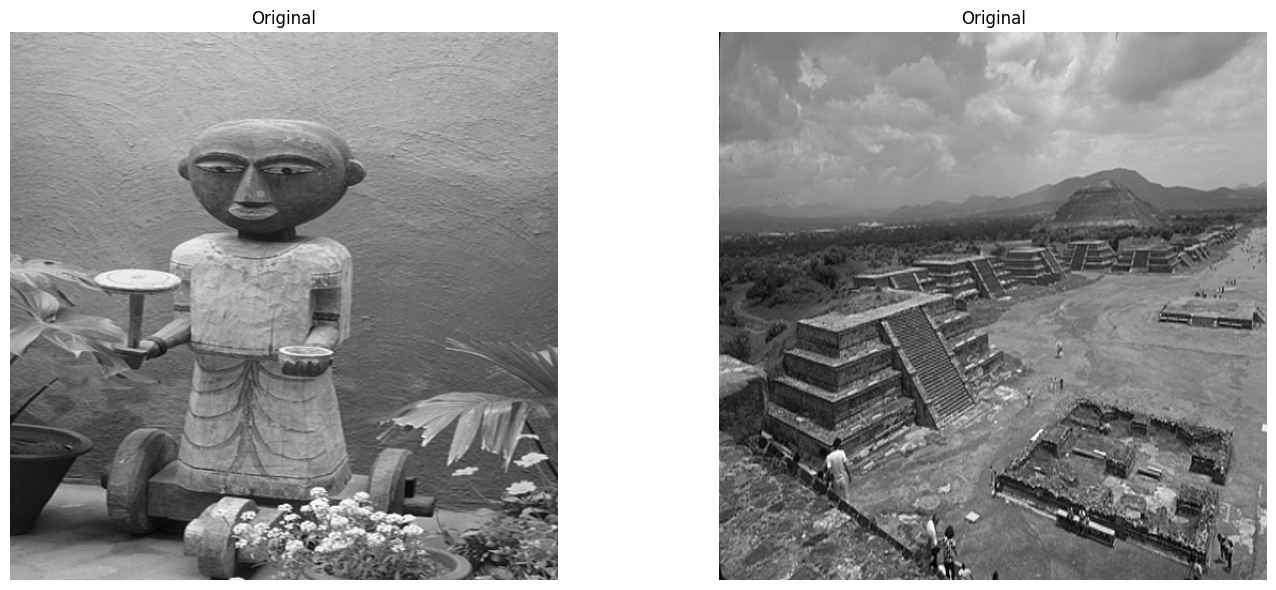

meanw psnr after embedding  67.29282705437743


Applying attacks: 100%|██████████| 8/8 [01:14<00:00,  9.32s/it, image=1, attack=DWT_MEIDAN, wpsnr=45.1, detected=1, param=kernel_size: [11, 11]]   

mean max attacked wpsnr  53.937082802396155
estimate points for invisibility + robusteness  6 0  total points = 6


In [11]:
total_history,total_succesfull_attacks,points =  utility.test_pipelines(
    alpha =0.48, 
    max_layer=1, 
    num_images=2,
    embedding_fn=embedding.embedding,
    attacks_list=attacks.attack_incremental_paramters,
    detection_fn=detection.detection)



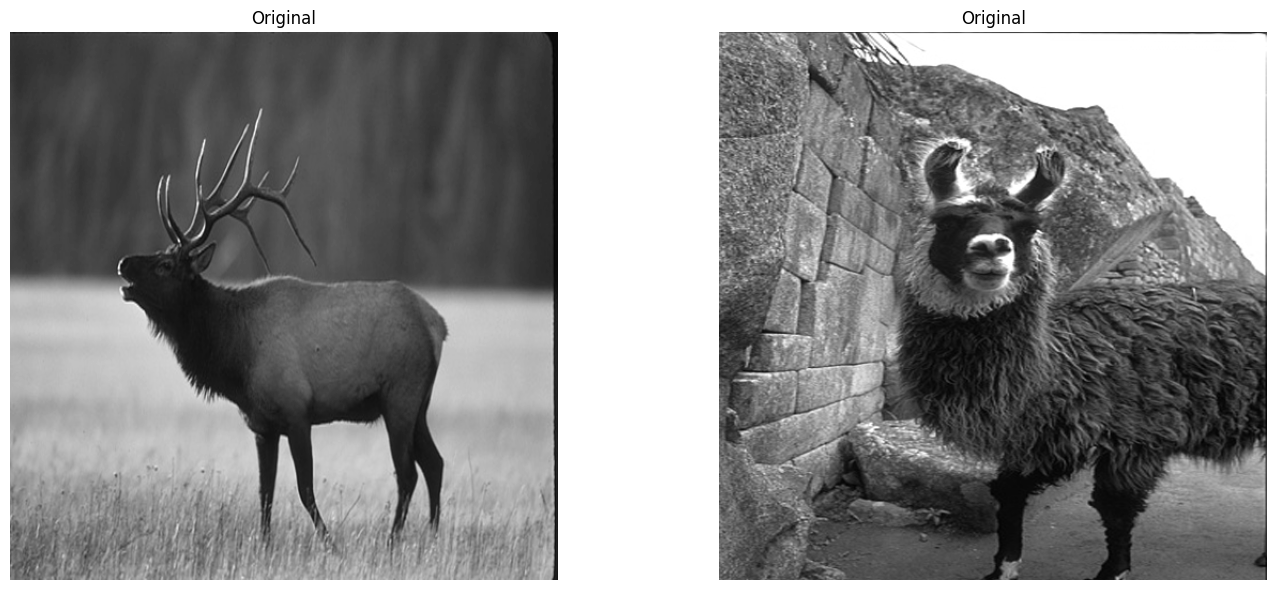

meanw psnr after embedding  66.36277950670498


max attacked wpsnr  54.126567880565105  on image  0
max attacked wpsnr  54.126567880565105  on image  1
mean max attacked wpsnr  54.126567880565105


In [12]:
total_history,total_succesfull_attacks,points = test_pipelines(alpha = 0.48, max_layer=1, num_images=2)


In [14]:
for s in total_succesfull_attacks:
    for succ in s:
        print("succesfull attack",succ["attack"]," on image ", succ['images'], " with wpsnr ", succ['wpsnr'])

{'images': 0, 'attack': 'AWGN', 'wpsnr': 37.288312946394434, 'param': 'std: 20'}
{'images': 0, 'attack': 'Blur', 'wpsnr': 9999999, 'param': 'sigma: 0'}
{'images': 0, 'attack': 'Blur', 'wpsnr': 45.21457764651851, 'param': 'sigma: 1'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 9999999, 'param': 'sigma: 0 alpha: 0'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 63.17764735244943, 'param': 'sigma: 0.5 alpha: 0.5'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 45.214578251460736, 'param': 'sigma: 1.0 alpha: 1.0'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 36.744590891035784, 'param': 'sigma: 1.5 alpha: 1.5'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 31.46315950083448, 'param': 'sigma: 2.0 alpha: 2.0'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 27.775716391059014, 'param': 'sigma: 2.5 alpha: 2.5'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 24.98262985301463, 'param': 'sigma: 3.0 alpha: 3.0'}
{'images': 0, 'attack': 'Sharpening', 'wpsnr': 22.737783628110826, 'param': 's

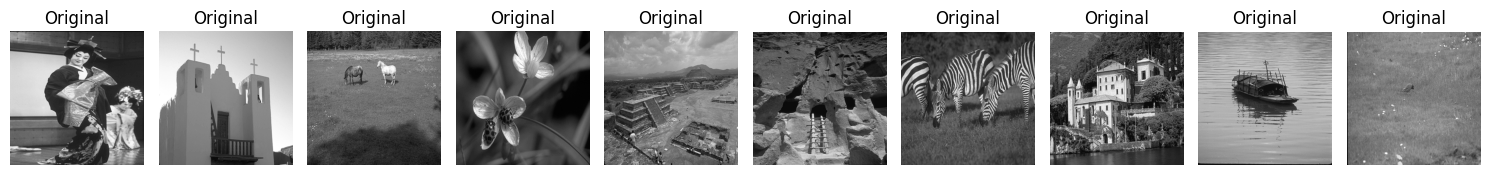

KeyboardInterrupt: 

In [13]:
test_pipelines(alpha = 0.48, max_layer=2, num_images=10)

In [17]:

utility.test_pipelines(alpha = 0.88, max_layer=2, num_images=10,embedding_fn=embedding.embedding,attack_list=attacks.attack_incremental_paramters,detection_fn=detection.detection)

TypeError: test_pipelines() got an unexpected keyword argument 'embedding_fn'

In [50]:
test_pipelines(alpha = 0.76, max_layer=1, num_images=10)

meanw psnr after embedding  61.38688159054182
image  0  wpsnr  69.12573397408426
image  1  wpsnr  67.9607151305014
image  2  wpsnr  67.56697269782947
image  3  wpsnr  68.69953945279913
image  4  wpsnr  67.86095872360725
image  5  wpsnr  68.6901677119235
image  6  wpsnr  66.44742167732556
image  7  wpsnr  68.17938355004966
image  8  wpsnr  64.85505209654067
image  9  wpsnr  67.94733728669516


In [22]:
import cv2
import numpy as np

def generate_watermark_mask(image_path):
    """
    Generates an approximate mask for the watermark using thresholding and edge detection.
    
    Parameters:
    - image_path (str): Path to the watermarked image.
    
    Returns:
    - mask (np.array): Binary mask indicating watermark location.
    """
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image not found.")
    
    # Step 1: Apply a Gaussian blur to smooth the image
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Step 2: Use adaptive thresholding to create a rough mask
    # You may need to adjust the threshold value depending on the watermark style
    _, binary_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 3: Detect edges to refine the watermark region
    edges = cv2.Canny(blurred, 50, 150)
    
    # Combine binary mask and edges to get a more defined watermark region
    combined_mask = cv2.bitwise_or(binary_mask, edges)
    
    # Step 4: Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    # Optional: further clean up the mask with opening to remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask


In [26]:
import cv2
import numpy as np

def remove_watermark_inpainting(image_path, mask_path, method='telea'):
    """
    Removes a watermark using inpainting.
    
    Parameters:
    - image_path (str): Path to the original image.
    - mask_path (str): Path to the binary mask indicating the watermark location.
    - method (str): Inpainting method ('telea' or 'ns' for Navier-Stokes).
    
    Returns:
    - result (np.array): Image with the watermark removed.
    """
    # Load the original image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found.")
    
    # Load the mask (binary image, white where the watermark is)
    mask = cv2.imread(mask_path, 0)
    if mask is None:
        raise ValueError("Mask not found.")
    
    # Choose inpainting method
    inpaint_method = cv2.INPAINT_TELEA if method == 'telea' else cv2.INPAINT_NS
    
    # Apply inpainting to remove watermark
    result = cv2.inpaint(image, mask, 3, inpaint_method)
    
    return result


In [30]:
# Generate the mask for the watermark
mask = generate_watermark_mask("lena_grey.bmp")

# Save or visualize the mask to verify
cv2.imwrite("generated_mask.bmp", mask)

# Use the generated mask in the inpainting function
result = remove_watermark_inpainting("watermarked.bmp", "generated_mask.bmp", method="telea")
cv2.imwrite("output_image.bmp", result)


True

In [ ]:
import cv2
import numpy as np

def detect_and_remove_watermark(image, blur_radius=5, inpaint_radius=3):
    """
    Automatically detects a watermark region, creates a mask, removes the watermark, 
    and smooths the edges for better quality.
    
    Parameters:
    - image_path (str): Path to the image containing a watermark.
    - blur_radius (int): Radius for Gaussian blur to smooth edges.
    - inpaint_radius (int): Radius for inpainting around the detected watermark.
    
    Returns:
    - result (np.array): Image with watermark removed and smoothed edges.
    """

    
    # Convert to grayscale for processing
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Detect regions that may contain the watermark
    # Apply adaptive thresholding to identify possible watermark regions
    _, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step 3: Refine mask by detecting edges
    edges = cv2.Canny(gray_image, 50, 150)
    
    # Combine threshold mask and edges to create a potential watermark mask
    combined_mask = cv2.bitwise_or(binary_mask, edges)
    
    # Use morphological operations to clean and close the detected mask
    kernel = np.ones((blur_radius, blur_radius), np.uint8)
    mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    # Step 4: Apply inpainting to remove the watermark
    inpainted_image = cv2.inpaint(image, mask, inpaint_radius, cv2.INPAINT_TELEA)
    
    # Step 5: Blur the edges of the inpainted area for a smoother transition
    # Detect edges of the mask
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Apply Gaussian blur selectively to the detected edge regions
    blurred_image = cv2.GaussianBlur(inpainted_image, (blur_radius, blur_radius), 0)
    result = np.where(edges_dilated[..., None] > 0, blurred_image, inpainted_image)
    
    return result
